# Analyzing a dataset with unlabeled CVE summaries from open-source third-party software

## The goal is to figure out what weakness each vulnerability is describing and visualizing the results. Using machine learning to categorize each summary, this might be possible.

# This data set will be analysed in 3 ways
## 1. Supervised text categorization with hierarchical attention network (HAN)
## 2. Unsupervised topic modelling visualisation with gensim and pyLDAvis
## 3. Vulnerability update time analysis

# 1. Supervised text categorization with hierarchical attention network (HAN)

## Supervised learning -> We need data.

### Not allowed to use external data sets -> Find patterns in current data set to be able to label and create training and test data

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
df = pd.read_pickle("cve_data.pickle")
df = df[df['summary'].notna()]
df = df[~df['summary'].str.contains('REJECT')]
df

,summary,updated_at
10,license.php in system-portal before 1.6.2 in op5 Monitor and op5 Appliance before 5.5.3 allows remote attackers to execute arbitrary commands via shell metacharacters in the timestamp parameter for an install action.,2014-01-02T16:24:00+00:00
11,op5config/welcome in system-op5config before 2.0.3 in op5 Monitor and op5 Appliance before 5.5.3 allows remote attackers to execute arbitrary commands via shell metacharacters in the password parameter.,2014-01-02T16:32:00+00:00
12,monitor/index.php in op5 Monitor and op5 Appliance before 5.5.1 allows remote authenticated users to obtain sensitive information such as database and user credentials via error messages that are triggered by (1) a malformed hoststatustypes parameter to status/service/all or (2) a crafted request to config.,2014-01-02T16:35:00+00:00
13,"op5 Monitor and op5 Appliance before 5.5.0 do not properly manage session cookies, which allows remote attackers to have an unspecified impact via unspecified vectors.",2014-01-02T16:39:00+00:00
14,Cross-site scripting (XSS) vulnerability in ProjectForge before 3.5.3 allows remote authenticated users to inject arbitrary web script or HTML via a validation message.,2014-01-02T18:21:00+00:00
...,...,...
125371,The DNS packet parsing/generation code in PowerDNS (aka pdns) Authoritative Server 3.4.x before 3.4.6 allows remote attackers to cause a denial of service (crash) via crafted query packets.,2020-01-17T21:28:00+00:00
125372,Directory traversal vulnerability in ZOHO ManageEngine Desktop Central (DC) before 9 build 90055 allows remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter in an LFU action to statusUpdate.,2020-01-17T22:15:00+00:00
125373,Directory traversal vulnerability in ZOHO ManageEngine Desktop Central (DC) before 9 build 90055 allows remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter to mdm/mdmLogUploader.,2020-01-17T22:15:00+00:00
125374,Directory traversal vulnerability in the agentLogUploader servlet in ZOHO ManageEngine Desktop Central (DC) and Desktop Central Managed Service Providers (MSP) edition before 9 build 90055 allows remote attackers to write to and execute arbitrary files as SYSTEM via a .. (dot dot) in the filename parameter.,2020-01-17T22:24:00+00:00


### Many different people writing CVE summaries, leading to very unstructured data.
### However, the base of many CVE summaries follow this pattern
#### (vulnerability type) vulnerability in (xxx) allow (vulnerability damage) via (vulnerability method)
#### On comparatively much rarer occasions, it is 'result in' or 'enable' instead of 'allow', and 'by' instead of 'via'

In [2]:
df[df['summary'].str.contains(' vulnerabilit') & df['summary'].str.contains(' in ') & df['summary'].str.contains(' allow') & df['summary'].str.contains(' via ')]

,summary,updated_at
14,Cross-site scripting (XSS) vulnerability in ProjectForge before 3.5.3 allows remote authenticated users to inject arbitrary web script or HTML via a validation message.,2014-01-02T18:21:00+00:00
15,Cross-site scripting (XSS) vulnerability in the Space function in Cybozu Garoon before 3.7.0 allows remote attackers to inject arbitrary web script or HTML via unspecified vectors.,2014-01-03T15:19:00+00:00
16,Cross-site scripting (XSS) vulnerability in the system-administration component in Cybozu Garoon before 3.7.0 allows remote attackers to inject arbitrary web script or HTML via unspecified vectors.,2014-01-03T15:20:00+00:00
17,Session fixation vulnerability in Cybozu Garoon before 3.7.2 allows remote attackers to hijack web sessions via unspecified vectors.,2014-01-03T15:20:00+00:00
18,"CRLF injection vulnerability in Cybozu Garoon 3.1 through 3.5 SP5, when Phone Messages forwarding is enabled, allows remote authenticated users to inject arbitrary e-mail headers via unspecified vectors.",2014-01-03T15:21:00+00:00
...,...,...
125370,Cross-site scripting (XSS) vulnerability in the Plotly plugin before 1.0.3 for WordPress allows remote authenticated users to inject arbitrary web script or HTML via a post.,2020-01-17T21:22:00+00:00
125372,Directory traversal vulnerability in ZOHO ManageEngine Desktop Central (DC) before 9 build 90055 allows remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter in an LFU action to statusUpdate.,2020-01-17T22:15:00+00:00
125373,Directory traversal vulnerability in ZOHO ManageEngine Desktop Central (DC) before 9 build 90055 allows remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter to mdm/mdmLogUploader.,2020-01-17T22:15:00+00:00
125374,Directory traversal vulnerability in the agentLogUploader servlet in ZOHO ManageEngine Desktop Central (DC) and Desktop Central Managed Service Providers (MSP) edition before 9 build 90055 allows remote attackers to write to and execute arbitrary files as SYSTEM via a .. (dot dot) in the filename parameter.,2020-01-17T22:24:00+00:00


### However, to be more lenient and get more different categories
### only filter by 'in' and 'allow' as many still follow that pattern

In [3]:
df = df[df['summary'].str.contains(' in ') & df['summary'].str.contains(' allow') ]
df

,summary,updated_at
10,license.php in system-portal before 1.6.2 in op5 Monitor and op5 Appliance before 5.5.3 allows remote attackers to execute arbitrary commands via shell metacharacters in the timestamp parameter for an install action.,2014-01-02T16:24:00+00:00
11,op5config/welcome in system-op5config before 2.0.3 in op5 Monitor and op5 Appliance before 5.5.3 allows remote attackers to execute arbitrary commands via shell metacharacters in the password parameter.,2014-01-02T16:32:00+00:00
12,monitor/index.php in op5 Monitor and op5 Appliance before 5.5.1 allows remote authenticated users to obtain sensitive information such as database and user credentials via error messages that are triggered by (1) a malformed hoststatustypes parameter to status/service/all or (2) a crafted request to config.,2014-01-02T16:35:00+00:00
14,Cross-site scripting (XSS) vulnerability in ProjectForge before 3.5.3 allows remote authenticated users to inject arbitrary web script or HTML via a validation message.,2014-01-02T18:21:00+00:00
15,Cross-site scripting (XSS) vulnerability in the Space function in Cybozu Garoon before 3.7.0 allows remote attackers to inject arbitrary web script or HTML via unspecified vectors.,2014-01-03T15:19:00+00:00
...,...,...
125371,The DNS packet parsing/generation code in PowerDNS (aka pdns) Authoritative Server 3.4.x before 3.4.6 allows remote attackers to cause a denial of service (crash) via crafted query packets.,2020-01-17T21:28:00+00:00
125372,Directory traversal vulnerability in ZOHO ManageEngine Desktop Central (DC) before 9 build 90055 allows remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter in an LFU action to statusUpdate.,2020-01-17T22:15:00+00:00
125373,Directory traversal vulnerability in ZOHO ManageEngine Desktop Central (DC) before 9 build 90055 allows remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter to mdm/mdmLogUploader.,2020-01-17T22:15:00+00:00
125374,Directory traversal vulnerability in the agentLogUploader servlet in ZOHO ManageEngine Desktop Central (DC) and Desktop Central Managed Service Providers (MSP) edition before 9 build 90055 allows remote attackers to write to and execute arbitrary files as SYSTEM via a .. (dot dot) in the filename parameter.,2020-01-17T22:24:00+00:00


### Now to label them. Everything that comes before 'in'

In [4]:
df['label'] = df['summary'].apply(lambda text: text.lower().split(' in ')[0] if len(text.lower().split(' in ')[0]) < 80 else 'unable to label')
df['label'] = df['label'].apply(lambda text: text.strip())

In [5]:
df['label'].value_counts()[:50]

cross-site scripting (xss) vulnerability                      6243
unable to label                                               6012
sql injection vulnerability                                   5338
unspecified vulnerability                                     5038
buffer overflow                                               2913
multiple cross-site scripting (xss) vulnerabilities           2592
directory traversal vulnerability                             2483
vulnerability                                                 1737
php remote file inclusion vulnerability                       1517
multiple sql injection vulnerabilities                        1511
stack-based buffer overflow                                   1424
a vulnerability                                               1316
an issue was discovered                                       1283
use-after-free vulnerability                                  1159
heap-based buffer overflow                                    

### (Above) The CVE summaries were structured enough that value_counts give somewhat good results
### Already here, we can see what vulnerabilities are the most common
### However, a lot of cleaning is needed. 
#### 1. Remove 'vulnerabilit' to make single and plural in one category
#### 2. Remove data due to label giving no information, or data that should not be there. e.g.  ** disputed **
#### 3. The word 'a' and 'multiple': 'cross-site scripting (xss)' should be bundled with 'multiple cross-site scripting (xss)'
#### 4. Parenthesis should be removed to bundle the labels without parenthesis. e.g. (xss)

### 1.

In [6]:
df['label'] = df['label'].apply(lambda text: text.split(' vulnerabilit')[0])

In [7]:
df['label'].value_counts()[:50]

cross-site scripting (xss)                    6285
unable to label                               6012
sql injection                                 5359
unspecified                                   5044
buffer overflow                               2920
multiple cross-site scripting (xss)           2596
directory traversal                           2506
vulnerability                                 1737
php remote file inclusion                     1524
multiple sql injection                        1511
a                                             1443
stack-based buffer overflow                   1425
an issue was discovered                       1283
use-after-free                                1167
heap-based buffer overflow                    1052
integer overflow                               820
cross-site request forgery (csrf)              810
multiple php remote file inclusion             604
multiple buffer overflows                      559
multiple unspecified           

### 2.

In [8]:
import re

df['label'] = df['label'].apply(lambda text: re.sub(r'^a ','',text))
df['label'] = df['label'].apply(lambda text: re.sub(r'^an ','',text))
df['label'] = df['label'].apply(lambda text: re.sub(r'^multiple ','',text))

In [9]:
df['label'].value_counts()[:30]

cross-site scripting (xss)           8937
sql injection                        6908
unable to label                      6012
unspecified                          5485
buffer overflow                      2970
directory traversal                  2900
php remote file inclusion            2128
vulnerability                        1737
a                                    1443
stack-based buffer overflow          1439
issue was discovered                 1285
use-after-free                       1204
cross-site request forgery (csrf)    1168
heap-based buffer overflow           1059
integer overflow                      846
buffer overflows                      612
format string                         486
untrusted search path                 443
webkit, as used                       421
unrestricted file upload              389
race condition                        378
cross-site scripting                  309
stack-based buffer overflows          291
unknown                           

### 3.

In [10]:
df['label'] = df['label'].apply(lambda text: text.split(' (')[0])

In [11]:
df['label'].value_counts()[:30]

cross-site scripting            9256
sql injection                   6908
unable to label                 6012
unspecified                     5485
buffer overflow                 2970
directory traversal             2900
php remote file inclusion       2128
vulnerability                   1737
a                               1443
stack-based buffer overflow     1439
issue was discovered            1285
cross-site request forgery      1235
use-after-free                  1204
heap-based buffer overflow      1059
integer overflow                 846
buffer overflows                 612
format string                    486
untrusted search path            445
webkit, as used                  421
unrestricted file upload         392
race condition                   378
stack-based buffer overflows     291
unknown                          283
integer overflows                263
open redirect                    256
memory leak                      242
the                              203
c

### 4.

In [12]:
df = df[~df['label'].str.fullmatch('unable to label')]
df = df[~df['label'].str.fullmatch('unspecified')]
df = df[~df['label'].str.fullmatch('a')]
df = df[~df['label'].str.fullmatch('this')]
df = df[~df['label'].str.fullmatch('unknown')]
df = df[~df['label'].str.fullmatch('multiple')]
df = df[~df['label'].str.fullmatch('webkit, as used')]
df = df[~df['label'].str.fullmatch('issue was discovered')]
df = df[~df['label'].str.fullmatch('the')]
df = df[~df['label'].str.fullmatch('the kernel')]
df = df[~df['label'].str.fullmatch('webkit')]
df = df[~df['label'].str.fullmatch('vulnerability')]
df = df[~df['label'].str.contains('\*\* disputed \*\*')]

In [13]:
df['label'].value_counts()[:30]

cross-site scripting            9256
sql injection                   6908
buffer overflow                 2970
directory traversal             2900
php remote file inclusion       2128
stack-based buffer overflow     1439
cross-site request forgery      1235
use-after-free                  1204
heap-based buffer overflow      1059
integer overflow                 846
buffer overflows                 612
format string                    486
untrusted search path            445
unrestricted file upload         392
race condition                   378
stack-based buffer overflows     291
integer overflows                263
open redirect                    256
memory leak                      242
crlf injection                   192
double free                      149
off-by-one error                 139
absolute path traversal          133
integer signedness error         118
xml external entity              105
integer underflow                105
session fixation                 104
h

### Observe many types of overflow, so bundled all together to avoid overlap

In [14]:
df['label'] = df['label'].apply(lambda text: 'overflow' if ' overflow' in text else text)

In [15]:
df['label'].value_counts()[:30]

cross-site scripting               9256
overflow                           7773
sql injection                      6908
directory traversal                2900
php remote file inclusion          2128
cross-site request forgery         1235
use-after-free                     1204
format string                       486
untrusted search path               445
unrestricted file upload            392
race condition                      378
open redirect                       256
memory leak                         242
crlf injection                      192
double free                         149
off-by-one error                    139
absolute path traversal             133
integer signedness error            118
integer underflow                   105
xml external entity                 105
session fixation                    104
microsoft edge                       94
eval injection                       80
win32k.sys                           79
index.php                            78


### Choose only categories with ample amount of data to avoid peculiar labels

In [16]:
min_rows = 100
category_list = list(df['label'].value_counts()[df['label'].value_counts() > min_rows].index)
df = df[df['label'].str.fullmatch('|'.join(category_list))]

In [17]:
df['label'].value_counts()[:]

cross-site scripting          9256
overflow                      7773
sql injection                 6908
directory traversal           2900
php remote file inclusion     2128
cross-site request forgery    1235
use-after-free                1204
format string                  486
untrusted search path          445
unrestricted file upload       392
race condition                 378
open redirect                  256
memory leak                    242
crlf injection                 192
double free                    149
off-by-one error               139
absolute path traversal        133
integer signedness error       118
xml external entity            105
integer underflow              105
session fixation               104
Name: label, dtype: int64

In [18]:
category_list

['cross-site scripting',
 'overflow',
 'sql injection',
 'directory traversal',
 'php remote file inclusion',
 'cross-site request forgery',
 'use-after-free',
 'format string',
 'untrusted search path',
 'unrestricted file upload',
 'race condition',
 'open redirect',
 'memory leak',
 'crlf injection',
 'double free',
 'off-by-one error',
 'absolute path traversal',
 'integer signedness error',
 'integer underflow',
 'xml external entity',
 'session fixation']

### Time to clean summary

#### To only focus on the symptoms of the vulnerability, and not the name and place of the vulnerability.

In [19]:
df['summary'] = df['summary'].apply(lambda text: text.split(' allow')[1])
df['summary'] = df['summary'].apply(lambda text: re.sub(r'^s ','',text))
df['summary'] = df['summary'].apply(lambda text: re.sub(r'^ing ','',text))
df

,summary,updated_at,label
14,remote authenticated users to inject arbitrary web script or HTML via a validation message.,2014-01-02T18:21:00+00:00,cross-site scripting
15,remote attackers to inject arbitrary web script or HTML via unspecified vectors.,2014-01-03T15:19:00+00:00,cross-site scripting
16,remote attackers to inject arbitrary web script or HTML via unspecified vectors.,2014-01-03T15:20:00+00:00,cross-site scripting
17,remote attackers to hijack web sessions via unspecified vectors.,2014-01-03T15:20:00+00:00,session fixation
18,remote authenticated users to inject arbitrary e-mail headers via unspecified vectors.,2014-01-03T15:21:00+00:00,crlf injection
...,...,...,...
125370,remote authenticated users to inject arbitrary web script or HTML via a post.,2020-01-17T21:22:00+00:00,cross-site scripting
125372,remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter in an LFU action to statusUpdate.,2020-01-17T22:15:00+00:00,directory traversal
125373,remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter to mdm/mdmLogUploader.,2020-01-17T22:15:00+00:00,directory traversal
125374,remote attackers to write to and execute arbitrary files as SYSTEM via a .. (dot dot) in the filename parameter.,2020-01-17T22:24:00+00:00,directory traversal


### There is a pattern in many CVE summaries that has 'NOTE', 'aka' or 'a different vector/vulnerability'

#### to avoid wrong classification, remove what comes after NOTE, as there is a high probability that it has nothing to do with the symptoms of the label

In [20]:
df[df['summary'].str.contains('NOTE')] 

,summary,updated_at,label
150,"remote attackers to inject arbitrary web script or HTML by requesting a nonexistent URI in conjunction with a crafted HTTP Referer header that is not properly handled in a 404 page. NOTE: there is no CVE for a ""URL redirection"" issue that some sources list separately.",2014-01-17T16:01:00+00:00,cross-site scripting
153,remote attackers to hijack the authentication of administrators for requests that (1) change an email address or (2) conduct script insertion attacks. NOTE: the provenance of this information is unknown; the details are obtained solely from third party information.,2014-01-17T18:51:00+00:00,cross-site request forgery
250,"remote attackers to hijack the authentication of administrators for requests that (1) change admin credentials in a request to setSysAdm.cgi, (2) enable remote management or (3) enable port forwarding in an Apply action to uapply.cgi, or (4) have unspecified impact via a request to setNTP.cgi. NOTE: some of these details are obtained from third party information.",2014-02-05T14:19:00+00:00,cross-site request forgery
362,"remote attackers to execute arbitrary code or cause a denial of service (application crash) via a crafted TIFF Internet Fax image file that has been compressed using CCITT Group 4 encoding, related to the EXPAND2D macro in libtiff/tif_fax3.h. NOTE: some of these details are obtained from third party information.",2014-02-21T04:39:00+00:00,overflow
396,remote attackers to hijack the authentication of (1) administrators for requests that change the administrator password via an update action to sw/admin_change_password.php or (2) unspecified victims for requests that add a topic or blog entry to sw/add_topic.php. NOTE: vector 2 can be leveraged to bypass the authentication requirements for exploiting vector 1 in CVE-2014-1914.,2014-02-21T05:06:00+00:00,cross-site request forgery
...,...,...,...
124255,"remote attackers to inject arbitrary web script or HTML via the newUser parameter. NOTE: this might not be a vulnerability, since an administrator might already have the privileges to create arbitrary script.",2020-01-09T21:32:00+00:00,cross-site scripting
124358,"remote attackers to execute arbitrary code via a crafted list file (aka a crafted file for the -ef option). NOTE: probably in most cases, the list file is a trusted file constructed by the program's user; however, there are some realistic situations in which a list file would be obtained from an untrusted remote source.",2020-01-10T19:07:00+00:00,overflow
124374,remote attackers to read arbitrary files via a .. (dot dot) in the class_key parameter. NOTE: some of these details are obtained from third party information.,2020-01-10T20:14:00+00:00,directory traversal
124486,remote attackers to inject arbitrary web script or HTML via the (1) id parameter to backup-edit.php; (2) title or (3) menu parameter to edit.php; or (4) path or (5) returnid parameter to filebrowser.php in admin/. NOTE: the path parameter in admin/upload.php vector is already covered by CVE-2012-6621.,2020-01-13T18:44:00+00:00,cross-site scripting


In [21]:
df['summary']= df['summary'].apply(lambda text: text.split('NOTE')[0] if 'NOTE' in text else text)

#### Same goes for 'aka'. Usually code numbers that are unique, which is not good to include.

In [22]:
df[df['summary'].str.contains('aka')] 

,summary,updated_at,label
400,"remote attackers to execute arbitrary code via a crafted message to TCP port 10212, aka ZDI-CAN-1623.",2014-02-21T05:06:00+00:00,directory traversal
401,"remote attackers to execute arbitrary code via a crafted HTTP request, aka ZDI-CAN-1622.",2014-02-21T05:06:00+00:00,directory traversal
423,"remote attackers to cause a denial of service (device reload) via certain matching traffic, aka Bug ID CSCuj16824.",2014-02-24T16:55:00+00:00,race condition
478,"remote attackers to read arbitrary files via a crafted URL, aka Bug IDs CSCth09343 and CSCts44049.",2014-02-27T21:37:00+00:00,directory traversal
901,"remote attackers to inject arbitrary HTTP headers and conduct redirection attacks via a crafted URL, aka Bug ID CSCuj61002.",2014-04-02T16:28:00+00:00,crlf injection
...,...,...,...
122926,"remote attackers to execute arbitrary code or cause a denial of service (use-after-free) by leveraging mishandling of end tags, as demonstrated by incorrect SVG processing, aka ZDI-CAN-3545.",2019-12-27T16:08:00+00:00,integer underflow
122927,"remote attackers to execute arbitrary code by leveraging mishandling of a root element, aka ZDI-CAN-3574.",2019-12-27T16:08:00+00:00,use-after-free
123030,"remote attackers to execute arbitrary code or cause a denial of service (use-after-free) by leveraging mishandling of end tags, as demonstrated by incorrect SVG processing, aka ZDI-CAN-3545.",2019-12-27T16:08:00+00:00,integer underflow
123031,"remote attackers to execute arbitrary code by leveraging mishandling of a root element, aka ZDI-CAN-3574.",2019-12-27T16:08:00+00:00,use-after-free


In [23]:
df['summary']= df['summary'].apply(lambda text: text.split('aka')[0] if 'aka' in text else text)

#### And also for a different vector/vulnerability

In [24]:
# to avoid wrong classification, remove what comes after NOTE:
df[df['summary'].str.contains(' different ') & df['summary'].str.contains('CVE')] 

,summary,updated_at,label
59,"remote attackers to execute arbitrary code via a long URL in the [playlist] section in a .pls file, a different vector than CVE-2009-1667.",2014-01-07T02:53:00+00:00,overflow
411,"attackers to execute arbitrary code via unspecified vectors, a different vulnerability than CVE-2013-0606, CVE-2013-0612, CVE-2013-0615, CVE-2013-0617, and CVE-2013-0621.",2014-02-21T18:46:00+00:00,overflow
419,"remote authenticated users to execute arbitrary SQL commands via unspecified vectors, a different vulnerability than CVE-2013-6929.",2014-02-21T19:44:00+00:00,sql injection
420,"remote authenticated users to execute arbitrary SQL commands via unspecified vectors, a different vulnerability than CVE-2013-6929.",2014-02-21T19:45:00+00:00,sql injection
917,"remote attackers to inject arbitrary web script or HTML via a crafted SVG image attachment, a different vulnerability than CVE-2012-5565.",2014-04-07T15:23:00+00:00,cross-site scripting
...,...,...,...
118037,"remote attackers to execute arbitrary code via a crafted PDF document, a different vulnerability than CVE-2016-0277, CVE-2016-0278, and CVE-2016-0279.",2019-10-16T12:40:00+00:00,overflow
121417,"remote authenticated administrators to inject arbitrary web script or HTML via the ""content brief"" or ""content extended"" field, a different vulnerability than CVE-2017-15878.",2019-12-09T17:05:00+00:00,cross-site scripting
123762,"remote attackers to perform a denial of service or possibly execute arbitrary code via a long TFTP error packet, a different vulnerability than CVE-2008-2161.",2020-01-03T14:43:00+00:00,overflow
123763,"remote attackers to perform a denial of service or execute arbitrary code via a long TFTP error packet, a different vulnerability than CVE-2018-10387 and CVE-2019-12568.",2020-01-03T14:49:00+00:00,overflow


In [25]:
df['summary']= df['summary'].apply(lambda text: text.split('different')[0] if (' different ' and 'CVE') in text else text)

#### Then we just remove the rest 158 that include CVE ids, as they are unique and should be to avoided

In [26]:
df[df['summary'].str.contains('CVE')]

,summary,updated_at,label
415,"remote attackers to hijack the authentication of administrators for requests that (1) add a new administrator via the AddUser action or (2) conduct cross-site scripting (XSS) attacks, as demonstrated by CVE-2013-4888.",2014-02-21T19:15:00+00:00,cross-site request forgery
578,"remote attackers to hijack the authentication of users for unspecified commands via unspecified vectors, as demonstrated by bypassing authentication requirements for CVE-2013-7106.",2014-03-06T04:50:00+00:00,cross-site request forgery
666,"remote attackers to hijack the authentication of administrators for requests that conduct SQL injection attacks via the q parameter, related to CVE-2012-6290.",2014-03-11T16:30:00+00:00,cross-site request forgery
690,"remote attackers to hijack the authentication of administrators for requests that conduct SQL injection attacks via the (1) groups[] parameter in a send action in the sendmail module or (2) query parameter in a sql_query action in the database module to admin.php, related to CVE-2013-3727.",2014-03-13T17:42:00+00:00,cross-site request forgery
762,"remote attackers to inject arbitrary web script or HTML by (1) providing a crafted playerId or (2) referencing an external domain, a related issue to CVE-2013-7342.",2014-03-24T14:56:00+00:00,cross-site scripting
...,...,...,...
102045,remote attackers to have unspecified impact via unknown vectors. Note: This vulnerability exists due to an incomplete patch for CVE-2016-2317.,2019-04-15T14:01:00+00:00,overflow
103326,"the attacker to execute arbitrary code remotely via a long HELP command, a related issue to CVE-2019-11395.",2019-05-03T17:26:00+00:00,overflow
108582,"remote attackers to determine the existence of files outside the application root via vectors involving a \ (backslash) character, a similar issue to CVE-2014-7818.",2019-08-08T15:43:00+00:00,directory traversal
119232,"for the creation of a user controlled XML file at an unintended location. When this is combined with CVE-2019-14451, an attacker can upload an ""external command"" configuration as a printer configuration, and achieve remote code execution. After exploitation, loading of the external command configuration is dependent on a system reboot or service restart.",2019-10-31T20:59:00+00:00,directory traversal


In [27]:
df = df[~df['summary'].str.contains('CVE')] 

#### Lastly, to avoid really long and peculiar cve summaries, remove too long summaries.

In [28]:
df[df['summary'].str.len() >1000]

,summary,updated_at,label
1307,"remote attackers to execute arbitrary SQL commands via the (1) orderby parameter to downloads.php; or remote authenticated users with certain permissions to execute arbitrary SQL commands via a (2) parameter name starting with ""delete_attach_"" in an edit action to forum/postedit.php; the (3) poll_opts[] parameter in a newthread action to forum/postnewthread.php; the (4) pm_email_notify, (5) pm_save_sent, (6) pm_inbox, (7) pm_sentbox, or (8) pm_savebox parameter to administration/settings_messages.php; the (9) thumb_compression, (10) photo_watermark_text_color1, (11) photo_watermark_text_color2, or (12) photo_watermark_text_color3 parameter to administration/settings_photo.php; the (13) enable parameter to administration/bbcodes.php; the (14) news_image, (15) news_image_t1, or (16) news_image_t2 parameter to administration/news.php; the (17) news_id parameter in an edit action to administration/news.php; or the (18) article_id parameter in an edit action to administration/articles.php.",2014-05-10T03:52:00+00:00,sql injection
1380,"remote attackers to execute arbitrary SQL commands via the (1) r_token variable in the dpm_get_pending_req_by_token, (2) dpm_get_cpr_by_fullid, (3) dpm_get_cpr_by_surl, (4) dpm_get_cpr_by_surls, (5) dpm_get_gfr_by_fullid, (6) dpm_get_gfr_by_surl, (7) dpm_get_pfr_by_fullid, (8) dpm_get_pfr_by_surl, (9) dpm_get_req_by_token, (10) dpm_insert_cpr_entry, (11) dpm_insert_gfr_entry, (12) dpm_insert_pending_entry, (13) dpm_insert_pfr_entry, (14) dpm_insert_xferreq_entry, (15) dpm_list_cpr_entry, (16) dpm_list_gfr_entry, or (17) dpm_list_pfr_entry function; the (18) surl variable in the dpm_get_cpr_by_surl function; the (19) to_surl variable in the dpm_get_cpr_by_surls function; the (20) u_token variable in the dpm_get_pending_reqs_by_u_desc, (21) dpm_get_reqs_by_u_desc, (22) dpm_get_spcmd_by_u_desc, (23) dpm_insert_pending_entry, (24) dpm_insert_spcmd_entry, or (25) dpm_insert_xferreq_entry function; the (26) s_token variable in the dpm_get_spcmd_by_token, (27) dpm_insert_cpr_entry, (28) dpm_insert_gfr_entry, (29) dpm_insert_pfr_entry, (30) dpm_insert_spcmd_entry, (31) dpm_update_cpr_entry, (32) dpm_update_gfr_entry, or (33) dpm_update_pfr_entry function; or remote administrators to execute arbitrary SQL commands via the (34) poolname variable in the dpm_get_pool_entry, (35) dpm_insert_fs_entry, (36) dpm_insert_pool_entry, (37) dpm_insert_spcmd_entry, (38) dpm_list_fs_entry, or (39) dpm_update_spcmd_entry function.",2014-05-16T03:58:00+00:00,sql injection
6844,"remote attackers to execute arbitrary SQL commands via the (1) ScriptSchedule parameter in the ScriptServlet servlet; the (2) winEventId or (3) winEventLog parameter in the WindowsEventLogsServlet servlet; the (4) processOS parameter in the ProcessesServlet servlet; the (5) group, (6) groupName, or (7) clientName parameter in the BackupExceptionsServlet servlet; the (8) valDB or (9) valFS parameter in the BackupAssociationServlet servlet; the (10) orderBy or (11) orderDir parameter in the HostStorageServlet servlet; the (12) fileName, (13) sortField, or (14) sortDirection parameter in the DuplicateFilesServlet servlet; the (15) orderFld or (16) orderDir parameter in the QuantumMonitorServlet servlet; the (17) exitCode parameter in the NbuErrorMessageServlet servlet; the (18) udfName, (19) displayName, (20) udfDescription, (21) udfDataValue, (22) udfSectionName, or (23) udfId parameter in the UserDefinedFieldConfigServlet servlet; the (24) sortField or (25) sortDirection parameter in the XiotechMonitorServlet servlet; the (26) sortField or (27) sortDirection parameter in the BexDriveUsageSummaryServlet servlet; the (28) state parameter in the ScriptServlet servlet; the (29) assignedNames parameter in the FileActionAssignmentServlet servlet; the (30) winEventSource parameter in the WindowsEventLogsServlet servlet; or the (31) name, (32) ipOne, (33) ipTwo, or (34) ipThree parameter in the XiotechMonitorServlet servlet.",

In [29]:
df = df[df['summary'].str.len() <400] 

In [30]:
df['label'].value_counts()[:20]

cross-site scripting          9081
overflow                      7687
sql injection                 6843
directory traversal           2849
php remote file inclusion     2054
use-after-free                1202
cross-site request forgery    1200
format string                  485
untrusted search path          434
unrestricted file upload       390
race condition                 372
open redirect                  255
memory leak                    241
crlf injection                 189
double free                    149
off-by-one error               137
absolute path traversal        132
integer signedness error       117
xml external entity            105
integer underflow              103
Name: label, dtype: int64

### Time for the typical ML formatting

In [31]:
from nltk.corpus import stopwords
import spacy
import re
stop_words = stopwords.words('english')
nlp = spacy.load("en_core_web_lg")
def remove_stop_words(text):
    global stop_words
    return " ".join(word for word in text.split(' ') if word not in stop_words)
def lemmatize(text):
    return " ".join(token.lemma_ for token in nlp(text))
def remove_special_characters(text):
    res = re.findall('(?!_)\w+(?<!_)', text.lower())
    res = " ".join(res)
    return res
def remove_alone_numbers(text):
    res = re.sub(r'\b[0-9]+\b\s*', '', text)
    return res

def format_text(text):
    text = remove_stop_words(text)
    text = lemmatize(text)
    text = remove_special_characters(text)
    text = remove_alone_numbers(text)
    return (text)

### But before that, cut down to lowest count to shorten format time and training time substantially
### It could also avoid bias that occurs when data amount among categories are skewed
### However, in this case, it would actually be better to not cut to lowest count,
### since som categories have comparatively much fewer data, but if time is short, it is acceptable. 

In [32]:
# def cut_to_lowest_count(df,category_list):
#     lowest_count = df['label'].value_counts()[-1]
#     cut_list = []
#     for category in category_list:
#         cut_list.append(df[df['label'].str.fullmatch(category)][:lowest_count])
#     return pd.concat(cut_list, axis=0)
# df = cut_to_lowest_count(df,category_list)

### If cutting is not done, then it is best to load the csv file that came with this submission that has done all the steps above and also formatted it

In [33]:
df = pd.read_csv('formatted_and_cut_with_label_cve_df.csv') # Load formatted 
df['label'] = df['label'].apply(lambda text: 'overflow' if ' overflow' in text else text) # This formatting process is specific for this ML
df = df[df['label'].str.fullmatch('|'.join(category_list))] # Taking the categories with ample rows

### This is because the formatting (especially lemmatization) takes about 30 min to complete on all summaries(the commented code below)

In [34]:
#df['summary'] = df['summary'].apply(format_text)
#df = df[df['summary'].str.len() != 0]

### Everything done above (except cutting) can be summarized like below
### This is how i made the formatted_and_cut_with_label_cve_df.csv file

In [35]:
# import pandas as pd
# import re
# pd.set_option('display.max_colwidth', None)
# df = pd.read_pickle("cve_data.pickle")
# df = df[df['summary'].notna()]
# df = df[~df['summary'].str.contains('REJECT')]
# df = df[df['summary'].str.contains(' in ') & df['summary'].str.contains(' allow') ]
# df['label'] = df['summary'].apply(lambda text: text.lower().split(' in ')[0] if len(text.lower().split(' in ')[0]) < 80 else 'unable to label')
# df['label'] = df['label'].apply(lambda text: text.strip())
# df['label'] = df['label'].apply(lambda text: text.split(' vulnerabilit')[0])
# df['label'] = df['label'].apply(lambda text: re.sub(r'^a ','',text))
# df['label'] = df['label'].apply(lambda text: re.sub(r'^an ','',text))
# df['label'] = df['label'].apply(lambda text: re.sub(r'^multiple ','',text))
# df['label'] = df['label'].apply(lambda text: text.split(' (')[0])
# df = df[~df['label'].str.fullmatch('unable to label')]
# df = df[~df['label'].str.fullmatch('unspecified')]
# df = df[~df['label'].str.fullmatch('a')]
# df = df[~df['label'].str.fullmatch('this')]
# df = df[~df['label'].str.fullmatch('unknown')]
# df = df[~df['label'].str.fullmatch('multiple')]
# df = df[~df['label'].str.fullmatch('webkit, as used')]
# df = df[~df['label'].str.fullmatch('issue was discovered')]
# df = df[~df['label'].str.fullmatch('the')]
# df = df[~df['label'].str.fullmatch('the kernel')]
# df = df[~df['label'].str.fullmatch('webkit')]
# df = df[~df['label'].str.fullmatch('vulnerability')]
# df = df[~df['label'].str.contains('\*\* disputed \*\*')]
# df['summary'] = df['summary'].apply(lambda text: text.split(' allow')[1])
# df['summary'] = df['summary'].apply(lambda text: re.sub(r'^s ','',text))
# df['summary'] = df['summary'].apply(lambda text: re.sub(r'^ing ','',text))
# df['summary']= df['summary'].apply(lambda text: text.split('NOTE')[0] if 'NOTE' in text else text)
# df['summary']= df['summary'].apply(lambda text: text.split('aka')[0] if 'aka' in text else text)
# df['summary']= df['summary'].apply(lambda text: text.split('different')[0] if (' different ' and 'CVE') in text else text)
# df = df[~df['summary'].str.contains('CVE')] 
# df = df[df['summary'].str.len() <400]

# df['summary'] = df['summary'].apply(format_text)
# df = df[df['summary'].str.len() != 0]

# df.to_csv('formatted_and_cut_with_label_cve_df.csv')

### If everything is done correctly, the cleaned dataframe should look like below (without unnamed column if loaded from csv file. no need to remove) 

In [36]:
df

,Unnamed: 0,summary,updated_at,label
3,14,remote authenticate user inject arbitrary web script html via validation message,2014-01-02 18:21:00+00:00,cross-site scripting
4,15,remote attacker inject arbitrary web script html via unspecified vector,2014-01-03 15:19:00+00:00,cross-site scripting
5,16,remote attacker inject arbitrary web script html via unspecified vector,2014-01-03 15:20:00+00:00,cross-site scripting
6,17,remote attacker hijack web session via unspecified vector,2014-01-03 15:20:00+00:00,session fixation
7,18,remote authenticate user inject arbitrary e mail header via unspecified vector,2014-01-03 15:21:00+00:00,crlf injection
...,...,...,...,...
55960,125370,remote authenticate user inject arbitrary web script html via post,2020-01-17 21:22:00+00:00,cross-site scripting
55962,125372,remote attacker execute arbitrary code via dot dot filename parameter lfu action statusupdate,2020-01-17 22:15:00+00:00,directory traversal
55963,125373,remote attacker execute arbitrary code via dot dot filename parameter mdm mdmloguploader,2020-01-17 22:15:00+00:00,directory traversal
55964,125374,remote attacker write execute arbitrary file system via dot dot filename parameter,2020-01-17 22:24:00+00:00,directory traversal


### Time for train_test_split

In [37]:
def split_df(dataframe, column_name, training_split, validation_split, test_split):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each category as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

train, val, test = split_df(df, 'label',0.8,0.1,0.1)

Total:  34124
Training:  27300 , Percentage:  0.8000234439104442
Validation:  3412 , Percentage:  0.09998827804477788
Test: 3412 , Percentage:  0.09998827804477788


In [38]:
import keras
MAX_FEATURES = 20000  # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 5  # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(df['summary'])
word_index = tokenizer.word_index


In [39]:
len(word_index)

15745

## Please download 'glove.6B.100d.txt' for word embedding for better and faster results
#### https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
## Training from scratch takes much longer time. (and probably not as good)
## If test does not allow predefined embedder, code will still run, but epochs and dimensions used might need to change for optimal results

In [40]:
import numpy as np
import os

embeddings_index = {}
glove_found = False
try:
    f = open(os.path.join(os.getcwd(), 'glove.6B.100d.txt'), encoding='utf8')
    print('glove found')
    glove_found = True
except(FileNotFoundError):
    print('No glove found, using empty embedder')
if glove_found == True:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    min_wordCount = 2
    absent_words = 0
    small_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    word_counts = tokenizer.word_counts
    for word, i in word_index.items():
        if word_counts[word] > min_wordCount:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
            else:
                absent_words += 1
        else:
            small_words += 1
    print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
          '% of total words')
    print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
          '% of total words')
    print(str(len(word_index)-small_words-absent_words) + ' words to proceed.')

glove found
Found 400000 word vectors.
Total absent words are 1137 which is 7.22 % of total words
Words with 2 or less mentions 11438 which is 72.65 % of total words
3170 words to proceed.


In [41]:
def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    """
    Converts a string to a numpy matrix where each word is tokenized.
    Arrays are zero-padded to max_sentences and max_words length.
    
    Input:    text           - string of sentences
              word_index     - trained word_index
              max_sentences  - maximum number of sentences allowed per document for HAN
              max_words      - maximum number of words in each sentence for HAN
              max_features   - maximum number of unique words to be tokenized
    Output:   data           - Numpy Matrix of size [max_sentences x max_words]
    """
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data

In [42]:
from keras.layers import Layer
from keras import initializers
from keras import backend as K

class AttentionLayer(Layer):
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        print(input_shape)
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

(None, 50, 100)
(None, 5, 100)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_input (InputLayer)     [(None, 50)]              0         
                                                                 
 word_embedding (Embedding)  (None, 50, 100)           1574600   
                                                                 
 word_gru (Bidirectional)    (None, 50, 100)           45600     
                                                                 
 word_dense (Dense)          (None, 50, 100)           10100     
                                                                 
 word_attention (AttentionLa  [(None, 100),            10200     
 yer)                         (None, 50, 1)]                     
                                                                 
Total params: 1,640,500
Trainable params: 65,900
Non-trainable params: 1,574,600
_______________

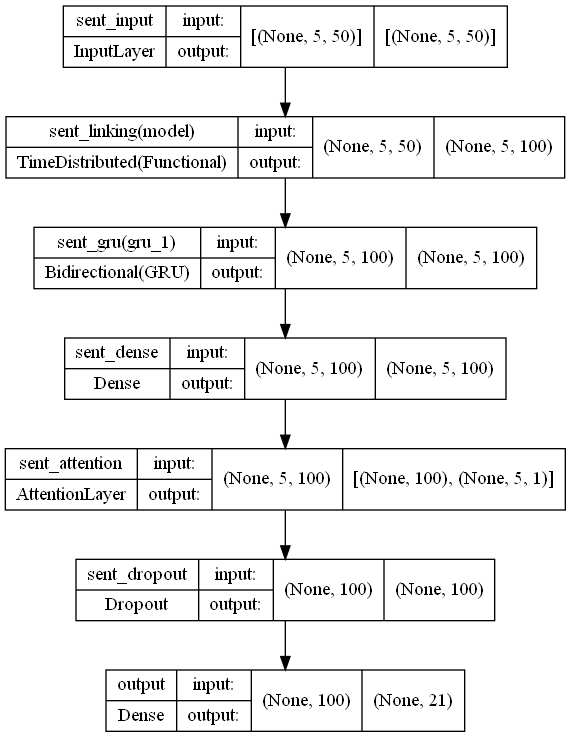

In [43]:
from keras.layers.embeddings import Embedding
from keras import Input, Model
from keras.layers import Bidirectional, GRU, Dense, TimeDistributed, Dropout
#from keras.utils.vis_utils import plot_model

if glove_found == True:
    embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,
                                weights = [embedding_matrix], trainable = False,
                                input_length=MAX_WORD_NUM,name='word_embedding')
else:
        embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,
                                input_length=MAX_WORD_NUM,name='word_embedding')
        

######### Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)

#Specifically 50 because the embedding matrix from glove is 100d (bilateral 50*2)
#It has attention both 50 back and forth
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)

#Tested many other, but relu is best
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 

#Attention layer 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)



######### Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')

# TimeDistributed to be able to apply the word attention layer while keeping the many to many relationship 
# Felt better than using RNN
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)

# Same as with word level
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)

# Drop out to hopefully avoid overfitting
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(len(category_list), activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())
#plot_model(model, to_file='model.png',show_shapes=True)

In [44]:
from sklearn import preprocessing
import nltk.tokenize as tokenize
def prepare_data(data):
    vectors = []
    for i in range(data['summary'].shape[0]):
        sequence = wordToSeq(data['summary'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
        vectors.append(sequence)
    x = np.array(vectors)
    
    enc = preprocessing.LabelEncoder()
    A=['label']
    enc.fit(data[A])
    new_cat_features = enc.transform(data[A])
    new_cat_features = new_cat_features.reshape(-1, 1) # Needs to be the correct shape
    ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
    y =ohe.fit_transform(new_cat_features)
    return x,y

x_train, y_train = prepare_data(train)
x_val, y_val = prepare_data(val)
x_test, y_test = prepare_data(test)

In [45]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(
    monitor="acc",
    min_delta=0.02,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=0.8,
    restore_best_weights=False,
)
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=100,callbacks=[callback])

Epoch 1/20
273/273 [==============================] - 88s 294ms/step - loss: 0.8152 - acc: 0.7897 - val_loss: 0.3534 - val_acc: 0.9083
Epoch 2/20
273/273 [==============================] - 77s 282ms/step - loss: 0.3357 - acc: 0.9155 - val_loss: 0.2797 - val_acc: 0.9302
Epoch 3/20
273/273 [==============================] - 74s 271ms/step - loss: 0.2752 - acc: 0.9276 - val_loss: 0.2513 - val_acc: 0.9326
Epoch 4/20
273/273 [==============================] - 75s 276ms/step - loss: 0.2484 - acc: 0.9344 - val_loss: 0.2474 - val_acc: 0.9338
Epoch 4: early stopping


In [46]:
results = model.evaluate(x_test, y_test, batch_size=100)

35/35 [==============================] - 4s 111ms/step - loss: 0.2468 - acc: 0.9370


## Test the model on original data

In [47]:
original_df = pd.read_pickle("cve_data.pickle")
original_df = original_df[original_df['summary'].notna()]
df.loc[:,'categorized_label'] = pd.Categorical(df.label)

In [48]:
def format_and_vectorize(text):
    print('Original Text')
    print(text)
    text = remove_stop_words(text)
    text = lemmatize(text)
    text = remove_special_characters(text)
    text = remove_alone_numbers(text)
    print('\nFormatted Text')
    print(text)
    paras = []
    for i in range(1):
        sequence = wordToSeq(text,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
        paras.append(sequence)
    return np.array(paras)

In [49]:
import random
def test_against_random_data(model,df,original_df, iloc_number = None):
    if(iloc_number == None):
        iloc_number = random.randint(0,len(original_df))
    print('iloc number: ' + str(iloc_number))
    random_summary = original_df.iloc[iloc_number]['summary']
    sample = format_and_vectorize(random_summary)
    res = model.predict(sample)
    categoryToCode = dict( enumerate(df['categorized_label'].cat.categories))
    res = res.flatten()
    found = False
    
    print('\nPredicted Label')
    for i in range(len(res)):
        if(res[i]*100 > 10): 
            print(str(round(res[i]*100,2)) + '%: ' + categoryToCode[i])

## Run the code below and decide whether it categorizes correct

In [50]:
test_against_random_data(model,df,original_df)

iloc number: 72910
Original Text
An exploitable out of bounds write vulnerability exists in the parsing of ELF Section Headers of Hopper Disassembler 3.11.20. A specially crafted ELF file can cause attacker controlled pointer arithmetic resulting in a partially controlled out of bounds write. An attacker can craft an ELF file with specific section headers to trigger this vulnerability.

Formatted Text
an exploitable bound write vulnerability exist parse elf section headers hopper disassembler a specially craft elf file cause attacker control pointer arithmetic resulting partially control bound write an attacker craft elf file specific section header trigger vulnerability

Predicted Label
10.6%: directory traversal
44.31%: overflow
20.16%: race condition


### My analysis: When the code is structured correctly, it has a chance of categorizing correctly. e.g. iloc_number 27798
### Sometimes it can even categorize somewhat correctly even though the correct category is not in the category list.
### Do remember that in the training set, the model cant see the label name. So it is a good indicator that it the model almost always predicts correctly when it sees 'xxx vulnerability ...'

In [51]:
test_against_random_data(model,df,original_df,27798)

iloc number: 27798
Original Text
Buffer overflow in the IsComponentInstalled method in Internet Explorer 6.0, when used on Windows 2000 before SP4 or Windows XP before SP1, allows remote attackers to execute arbitrary code via JavaScript that calls IsComponentInstalled with a long first argument.

Formatted Text
buffer overflow iscomponentinstalled method internet explorer use windows sp4 windows xp sp1 allow remote attacker execute arbitrary code via javascript call iscomponentinstalled long first argument

Predicted Label
98.35%: overflow


### If forgotten, below is the category_list

In [52]:
category_list

['cross-site scripting',
 'overflow',
 'sql injection',
 'directory traversal',
 'php remote file inclusion',
 'cross-site request forgery',
 'use-after-free',
 'format string',
 'untrusted search path',
 'unrestricted file upload',
 'race condition',
 'open redirect',
 'memory leak',
 'crlf injection',
 'double free',
 'off-by-one error',
 'absolute path traversal',
 'integer signedness error',
 'integer underflow',
 'xml external entity',
 'session fixation']

# 2. Unsupervised topic modelling visualisation with gensim and pyLDAvis

### Using the data from before

In [53]:
df = pd.read_csv('formatted_and_cut_with_label_cve_df.csv') 
df['summary'] = df['label'].apply(remove_special_characters) + ' ' + df['summary']
df

,Unnamed: 0,summary,updated_at,label
0,10,license php remote attacker execute arbitrary command via shell metacharacter timestamp parameter install action,2014-01-02 16:24:00+00:00,license.php
1,11,op5config welcome remote attacker execute arbitrary command via shell metacharacter password parameter,2014-01-02 16:32:00+00:00,op5config/welcome
2,12,monitor index php remote authenticate user obtain sensitive information database user credential via error message trigger malformed hoststatustype parameter status service all craft request config,2014-01-02 16:35:00+00:00,monitor/index.php
3,14,cross site scripting remote authenticate user inject arbitrary web script html via validation message,2014-01-02 18:21:00+00:00,cross-site scripting
4,15,cross site scripting remote attacker inject arbitrary web script html via unspecified vector,2014-01-03 15:19:00+00:00,cross-site scripting
...,...,...,...,...
55961,125371,the dns packet parsing generation code remote attacker cause denial service crash via craft query packet,2020-01-17 21:28:00+00:00,the dns packet parsing/generation code
55962,125372,directory traversal remote attacker execute arbitrary code via dot dot filename parameter lfu action statusupdate,2020-01-17 22:15:00+00:00,directory traversal
55963,125373,directory traversal remote attacker execute arbitrary code via dot dot filename parameter mdm mdmloguploader,2020-01-17 22:15:00+00:00,directory traversal
55964,125374,directory traversal remote attacker write execute arbitrary file system via dot dot filename parameter,2020-01-17 22:24:00+00:00,directory traversal


## Processing for pyLDAvis

In [54]:
import gensim
from gensim.utils import simple_preprocess

#Preprocessing all the words
def process_words(texts):
    processed_words = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        processed_words.append(new)
    return processed_words

data_words = process_words(df['summary'])

### add bigrams and trigrams

In [55]:
#Trigram is standard and probably enough, but pentagrams seems to work well
bigram_phrases = gensim.models.Phrases(data_words, min_count=30)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words])
quadgram_phrases = gensim.models.Phrases(trigram_phrases[data_words])
pentagram_phrases = gensim.models.Phrases(quadgram_phrases[data_words])

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)
quadgram = gensim.models.phrases.Phraser(quadgram_phrases)
pentagram = gensim.models.phrases.Phraser(pentagram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

def make_quadgrams(texts):
    return ([quadgram[trigram[bigram[doc]]] for doc in texts])
def make_pentagrams(texts):
    return ([pentagram[quadgram[trigram[bigram[doc]]]] for doc in texts])


data_bigrams = make_bigrams(data_words)
data_trigrams = make_trigrams(data_bigrams)
data_quadgrams = make_quadgrams(data_trigrams)
data_pentagrams = make_pentagrams(data_quadgrams)

## Format it for pyLDAvis

In [56]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_pentagrams)

texts = data_pentagrams

corpus = [id2word.doc2bow(text) for text in texts]

## Test different number of topics and hope for the best

In [57]:
#all of the numbers (num_topics,random_state, update_every, chunksize, etc) is just to guess
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize= 10000,
                                           passes=5,
                                           alpha="auto")

## 10 Topics
### Seems like it is doing the best. 
### Looking back and for between what this graph depicts and OWASP top 10 security risks, some if it is correlating
### Some key points to notice:
#### 1. php is its own topic (2), with different injections in it
#### 2. html and cross_site_scripting in topic (4)
#### 3. hovering over 'attacker' it lights up 1 2 4, where attacker is actively attacking
#### 4. topic 1 seems to be arbitrary code execution and buffer overflow causing denial of service

In [58]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.143558  0.252702       1        1  20.292909
8     -0.332298  0.141999       2        1  19.984814
1      0.077103  0.321068       3        1  14.120339
4     -0.326110 -0.091588       4        1  13.586886
0      0.160232  0.005251       5        1   7.533234
3     -0.039332 -0.049569       6        1   7.474130
2      0.302548  0.200653       7        1   7.300888
7      0.376406 -0.110231       8        1   4.106573
6     -0.178103 -0.281059       9        1   3.231687
5      0.103112 -0.389224      10        1   2.368540, topic_info=           Term          Freq         Total Category  logprob  loglift
8           php  15125.000000  15125.000000  Default  30.0000  30.0000
4       execute  20979.000000  20979.000000  Default  29.0000  29.0000
36         html  10011.000000  10011.000000  Default  28.0000  28.0000
7     parameter  18786.000000  18786.000000  Default  27.0000  27.0000
2      attacker  36026.000000  36026.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2806     target     86.265165    168.017389  Topic10  -5.1698   3.0763
307     connect     88.300030    263.915891  Topic10  -5.1465   2.6480
208         url    154.788900   4068.698127  Topic10  -4.5852   0.4739
431     library     75.493972    239.463659  Topic10  -5.3032   2.5885
422      attack     83.769127    723.015084  Topic10  -5.1992   1.5875

[638 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
6965       5  0.987114               able
381        1  0.136425             access
381        3  0.056503             access
381        4  0.014126             access
381        5  0.195531             access
...      ...       ...                ...
1183       1  0.015926       xml_document
1183       3  0.979424       xml_document
1685      10  0.995127         xss_attack
11642      4  0.996620  xss_vulnerability
9331       6  0.987151                xxe

[1198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 2, 5, 1, 4, 3, 8, 7, 6])

## 15 Topics
### Better in some places, for example topic 4 being denial of service specific. -> that it causes crashes

In [59]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15,
                                           random_state=100,
                                           update_every=1,
                                           chunksize= 10000,
                                           passes=5,
                                           alpha="auto")
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.159166  0.348227       1        1  15.062077
4      0.053112  0.360731       2        1  12.634454
9     -0.226912  0.177648       3        1  10.150295
10     0.284499  0.112950       4        1   9.857872
14    -0.113591  0.202178       5        1   8.074393
12    -0.214450  0.004943       6        1   7.293454
0      0.067640 -0.036203       7        1   6.345322
11     0.202585  0.336070       8        1   6.245113
13     0.042264 -0.273427       9        1   5.228369
2     -0.234622 -0.231400      10        1   4.425697
3      0.241804 -0.141431      11        1   4.312687
1      0.351146 -0.024886      12        1   3.577800
6     -0.404558 -0.068021      13        1   2.533610
7      0.240715 -0.345464      14        1   2.393321
5     -0.130466 -0.421916      15        1   1.865536, topic_info=                        Term          Freq         Total Category  logprob  \
8                        php  14994.000000  14994.000000  Default  30.0000   
4                    execute  21149.000000  21149.000000  Default  29.0000   
7                  parameter  18817.000000  18817.000000  Default  28.0000   
36                      html  10432.000000  10432.000000  Default  27.0000   
1                  arbitrary  20002.000000  20002.000000  Default  26.0000   
...                      ...           ...           ...      ...      ...   
38                validation     62.477349    125.383790  Topic15  -5.2537   
374   activex_control_remote     56.961593     85.391132  Topic15  -5.3461   
93                  specific     59.353593    108.980607  Topic15  -5.3050   
422                   attack     74.631022    770.423774  Topic15  -5.0759   
5381               malicious     63.384816    561.485444  Topic15  -5.2393   

      loglift  
8     30.0000  
4     29.0000  
7     28.0000  
36    27.0000  
1     26.0000  
...       ...  
38     3.2850  
374    3.5768  
93     3.3740  
422    1.6472  
5381   1.8003  

[919 rows x 6 columns], token_table=      Topic      Freq                     Term
term                                          
6965      2  0.994782                     able
713       6  0.990326  absolute_path_traversal
381       4  0.003659                   access
381       5  0.041350                   access
381       6  0.105021                   access
...     ...       ...                      ...
5982      8  0.979421                     year
1367      6  0.891296                      zip
1367      9  0.042108                      zip
1367     10  0.056145                      zip
1367     13  0.007018                      zip

[1886 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 10, 11, 15, 13, 1, 12, 14, 3, 4, 2, 7, 8, 6])

## 5 Topics
### Very hard to categorize. Too many categories seem to go into one topic.

In [60]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize= 10000,
                                           passes=5,
                                           alpha="auto")
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.221001 -0.185326       1        1  27.678337
0     -0.044091  0.187185       2        1  22.775516
4     -0.153033 -0.217597       3        1  16.695688
3     -0.267449  0.078622       4        1  16.695179
2      0.243572  0.137116       5        1  16.155279, topic_info=                     Term          Freq         Total Category  logprob  \
96                   code  12809.000000  12809.000000  Default  30.0000   
4                 execute  19733.000000  19733.000000  Default  29.0000   
36                   html   9183.000000   9183.000000  Default  28.0000   
1               arbitrary  18230.000000  18230.000000  Default  27.0000   
35   cross_site_scripting   7527.000000   7527.000000  Default  26.0000   
..                    ...           ...           ...      ...      ...   
3                 command    490.686283   2167.790291   Topic5  -5.3514   
436           demonstrate    411.108283   1366.650618   Topic5  -5.5283   
18                  craft    553.910075  10552.515110   Topic5  -5.2302   
354               content    352.591140    808.883709   Topic5  -5.6819   
9                  remote    388.099635  27645.938196   Topic5  -5.5859   

     loglift  
96   30.0000  
4    29.0000  
36   28.0000  
1    27.0000  
35   26.0000  
..       ...  
3     0.3373  
436   0.6217  
18   -1.1242  
354   0.9926  
9    -2.4430  

[329 rows x 6 columns], token_table=       Topic      Freq                     Term
term                                           
6965       5  0.989372                     able
713        5  0.989306  absolute_path_traversal
381        1  0.259627                   access
381        2  0.126181                   access
381        3  0.030972                   access
...      ...       ...                      ...
72         5  0.713080                    write
1475       1  0.207174                      xss
1475       2  0.091297                      xss
1475       4  0.702284                      xss
11642      3  0.997433        xss_vulnerability

[506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 4, 3])

# 3. Vulnerability update time analysis

### Lets start by analysing the vulnerabilities that could (not necesarrily correctly) be labeled.

In [61]:
df = pd.read_csv('formatted_and_cut_with_label_cve_df.csv')  
df['label'] = df['label'].apply(lambda text: 'overflow' if ' overflow' in text else text)  # In this case, we bundle all the overflow cve
df['updated_at'] = df['updated_at'].apply(pd.to_datetime)
df

,Unnamed: 0,summary,updated_at,label
0,10,remote attacker execute arbitrary command via shell metacharacter timestamp parameter install action,2014-01-02 16:24:00+00:00,license.php
1,11,remote attacker execute arbitrary command via shell metacharacter password parameter,2014-01-02 16:32:00+00:00,op5config/welcome
2,12,remote authenticate user obtain sensitive information database user credential via error message trigger malformed hoststatustype parameter status service all craft request config,2014-01-02 16:35:00+00:00,monitor/index.php
3,14,remote authenticate user inject arbitrary web script html via validation message,2014-01-02 18:21:00+00:00,cross-site scripting
4,15,remote attacker inject arbitrary web script html via unspecified vector,2014-01-03 15:19:00+00:00,cross-site scripting
...,...,...,...,...
55961,125371,remote attacker cause denial service crash via craft query packet,2020-01-17 21:28:00+00:00,the dns packet parsing/generation code
55962,125372,remote attacker execute arbitrary code via dot dot filename parameter lfu action statusupdate,2020-01-17 22:15:00+00:00,directory traversal
55963,125373,remote attacker execute arbitrary code via dot dot filename parameter mdm mdmloguploader,2020-01-17 22:15:00+00:00,directory traversal
55964,125374,remote attacker write execute arbitrary file system via dot dot filename parameter,2020-01-17 22:24:00+00:00,directory traversal


## Vulnerability update analysis for more common vulnerabilities

In [62]:
max_rows = 999999
min_rows = 200
category_list = list(df['label'].value_counts()[(df['label'].value_counts() > min_rows) & (df['label'].value_counts() < max_rows)].index)
high_value_df = df[df['label'].str.fullmatch('|'.join(category_list))]

In [63]:
import datetime
def df_by_date(df):
    cve_dic = {}
    cve_dic['date'] = []
    for i in range(min(df['date']),max(df['date'])+1):
        cve_by_date=df[(df['date']>=i) & (df['date']<i+1)]['label'].value_counts()
        cve_dic['date'].append(i)
        for index, value in cve_by_date.items():
            if index in cve_dic:
                cve_dic[index].append(value)
            else:
                cve_dic[index] = [value]
    cve_count_df = pd.DataFrame(dict([(index,pd.Series(value)) for index,value in cve_dic.items() ]))
    cve_count_df = cve_count_df.fillna(0)
    cve_count_df = cve_count_df.set_index('date')
    return cve_count_df


In [64]:
high_value_df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).day)
cve_by_day = df_by_date(high_value_df)
high_value_df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).month)
cve_by_month = df_by_date(high_value_df)
high_value_df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).year)
cve_by_year = df_by_date(high_value_df)

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

## Vulnerability by year
### interesting that there was a spike vulnerability updates during 2017 for about all of the common vulnerabilities

<AxesSubplot:xlabel='date'>

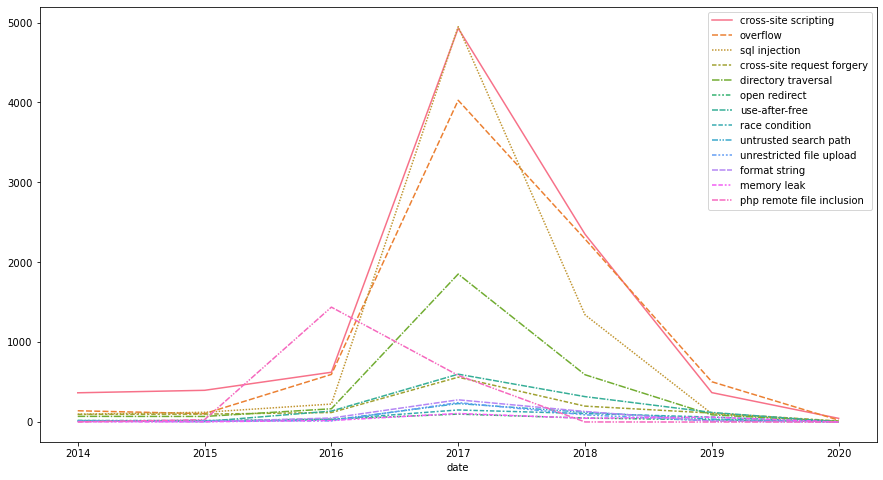

In [66]:
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_year)

## Vulnerability by year
### Vulnerability updates seem to occur more during fall

<AxesSubplot:xlabel='date'>

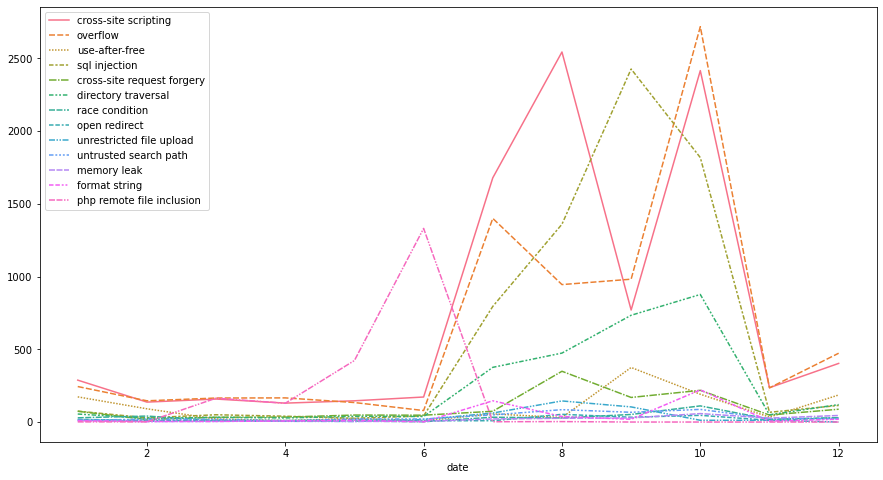

In [67]:
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_month)

## Vulnerability by day
### Might not be important, as vulnerability updates might come in chunks depending on work days and who writes them.

<AxesSubplot:xlabel='date'>

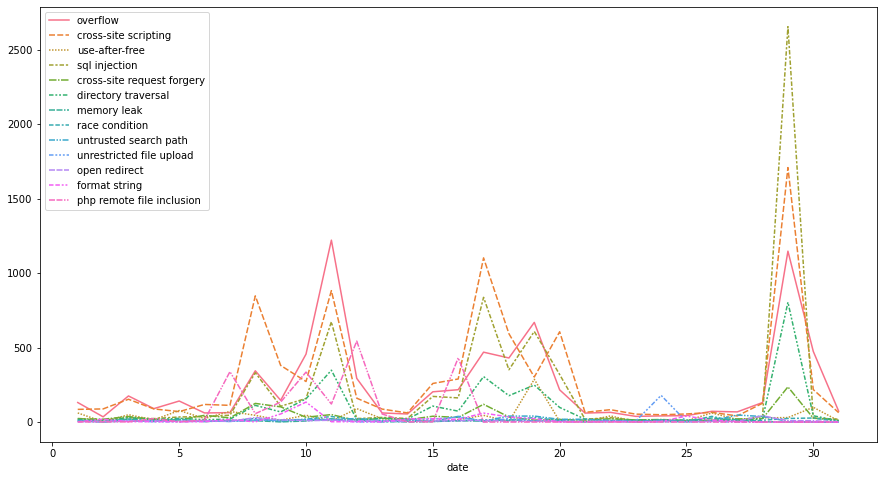

In [68]:
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_day)

## Vulnerability update analysis for the rarer vulnerabilities

In [69]:
max_rows = 200
min_rows = 50
category_list = list(df['label'].value_counts()[(df['label'].value_counts() > min_rows) & (df['label'].value_counts() < max_rows)].index)
low_value_df = df[df['label'].str.fullmatch('|'.join(category_list))]

### Here we can see that it is a little bit different.
### Going by year, the 2017 spike is still a prevalent, but some spiked even at 2016
### Going by month and day, the spikes are more widespread

<AxesSubplot:xlabel='date'>

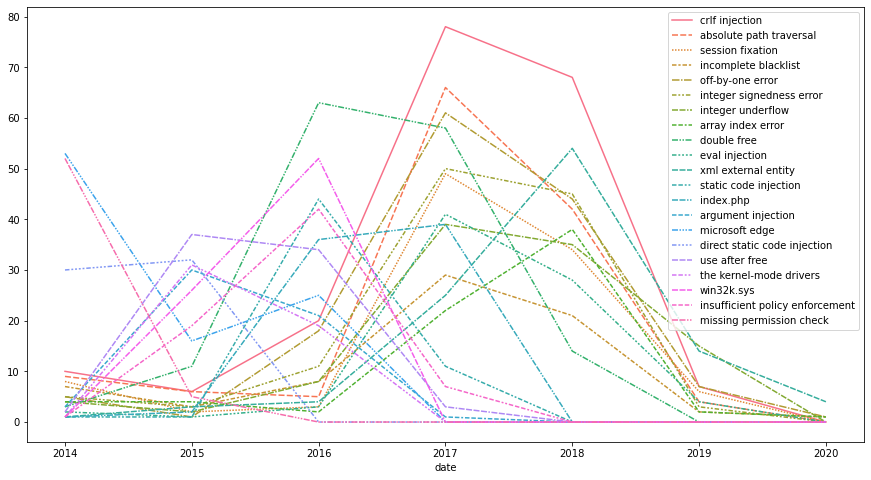

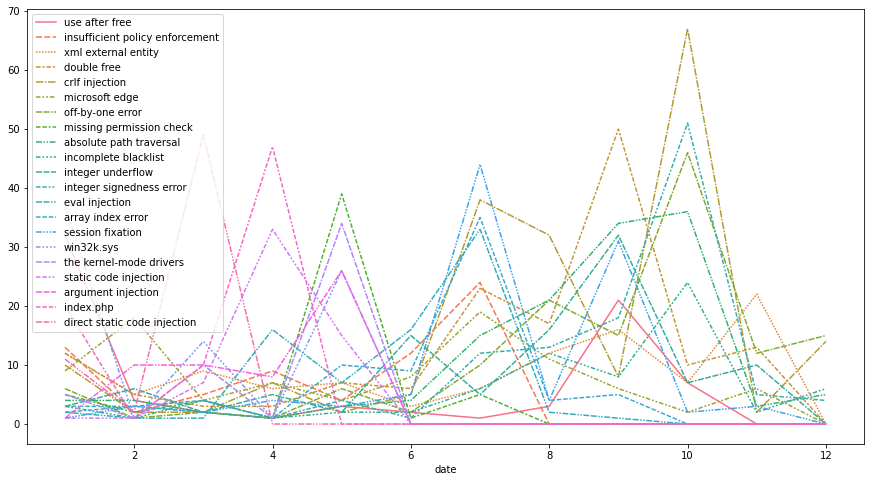

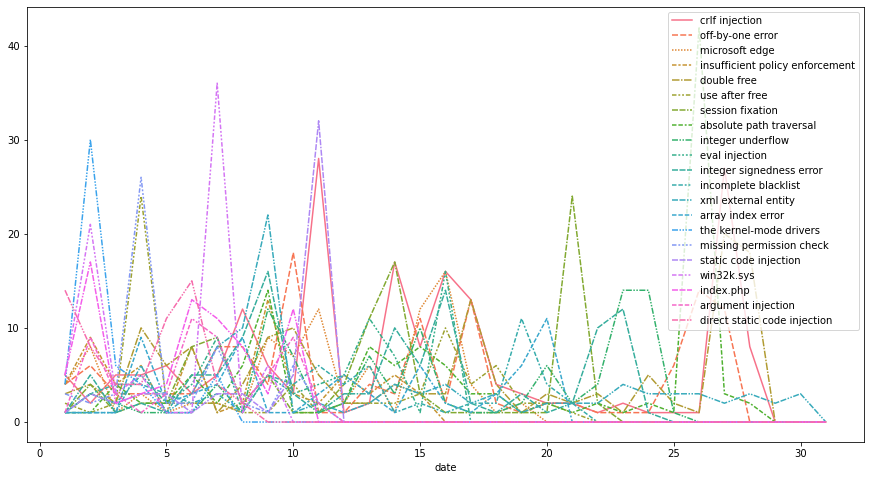

In [70]:
low_value_df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).day)
cve_by_day = df_by_date(low_value_df)
low_value_df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).month)
cve_by_month = df_by_date(low_value_df)
low_value_df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).year)
cve_by_year = df_by_date(low_value_df)
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_year)
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_month)
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_day)

# Time analysis on the whole data set

In [71]:
df = pd.read_pickle("cve_data.pickle")
df = df[df['summary'].notna()]
df = df[~df['summary'].str.contains('REJECT')]
df['updated_at'] = df['updated_at'].apply(pd.to_datetime)
df

,summary,updated_at
10,license.php in system-portal before 1.6.2 in op5 Monitor and op5 Appliance before 5.5.3 allows remote attackers to execute arbitrary commands via shell metacharacters in the timestamp parameter for an install action.,2014-01-02 16:24:00+00:00
11,op5config/welcome in system-op5config before 2.0.3 in op5 Monitor and op5 Appliance before 5.5.3 allows remote attackers to execute arbitrary commands via shell metacharacters in the password parameter.,2014-01-02 16:32:00+00:00
12,monitor/index.php in op5 Monitor and op5 Appliance before 5.5.1 allows remote authenticated users to obtain sensitive information such as database and user credentials via error messages that are triggered by (1) a malformed hoststatustypes parameter to status/service/all or (2) a crafted request to config.,2014-01-02 16:35:00+00:00
13,"op5 Monitor and op5 Appliance before 5.5.0 do not properly manage session cookies, which allows remote attackers to have an unspecified impact via unspecified vectors.",2014-01-02 16:39:00+00:00
14,Cross-site scripting (XSS) vulnerability in ProjectForge before 3.5.3 allows remote authenticated users to inject arbitrary web script or HTML via a validation message.,2014-01-02 18:21:00+00:00
...,...,...
125371,The DNS packet parsing/generation code in PowerDNS (aka pdns) Authoritative Server 3.4.x before 3.4.6 allows remote attackers to cause a denial of service (crash) via crafted query packets.,2020-01-17 21:28:00+00:00
125372,Directory traversal vulnerability in ZOHO ManageEngine Desktop Central (DC) before 9 build 90055 allows remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter in an LFU action to statusUpdate.,2020-01-17 22:15:00+00:00
125373,Directory traversal vulnerability in ZOHO ManageEngine Desktop Central (DC) before 9 build 90055 allows remote attackers to execute arbitrary code via a .. (dot dot) in the fileName parameter to mdm/mdmLogUploader.,2020-01-17 22:15:00+00:00
125374,Directory traversal vulnerability in the agentLogUploader servlet in ZOHO ManageEngine Desktop Central (DC) and Desktop Central Managed Service Providers (MSP) edition before 9 build 90055 allows remote attackers to write to and execute arbitrary files as SYSTEM via a .. (dot dot) in the filename parameter.,2020-01-17 22:24:00+00:00


In [72]:
def df_by_date_without_label(df):
    cve_dic = {}
    cve_dic['date'] = []
    cve_dic['count'] = []
    for i in range(min(df['date']),max(df['date'])+1):
        cve_by_date=df[(df['date']>=i) & (df['date']<i+1)].count()[0]
        cve_dic['date'].append(i)
        cve_dic['count'].append(cve_by_date)
    cve_count_df = pd.DataFrame.from_dict(cve_dic)
    cve_count_df = cve_count_df.set_index('date')
    return cve_count_df

In [73]:
df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).day)
cve_by_day = df_by_date_without_label(df)
df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).month)
cve_by_month = df_by_date_without_label(df)
df['date'] = df['updated_at'].apply(lambda date: datetime.datetime.date(date).year)
cve_by_year = df_by_date_without_label(df)

<AxesSubplot:xlabel='date'>

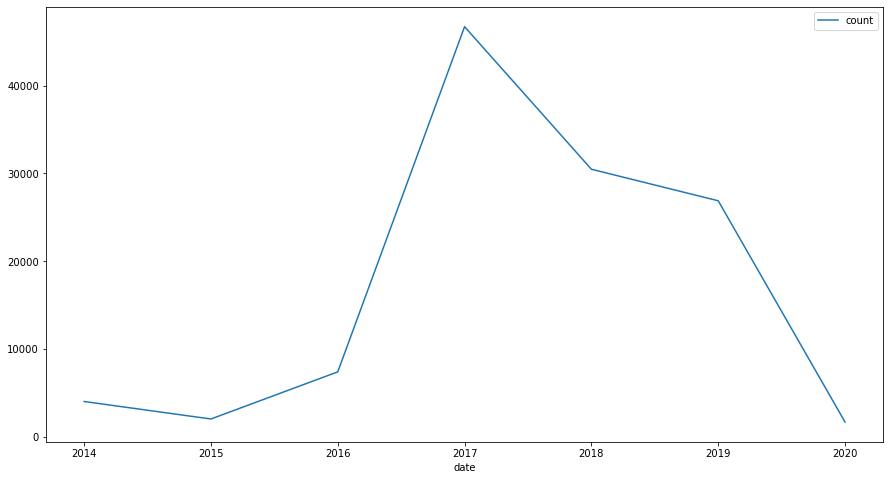

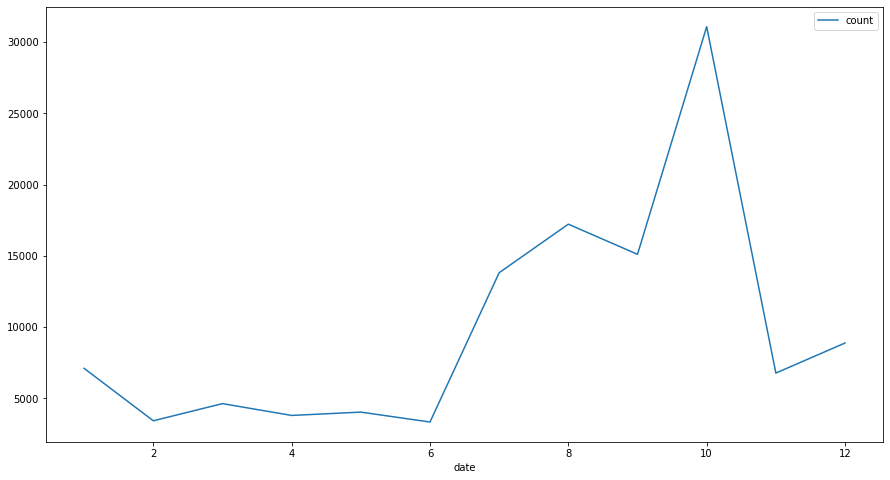

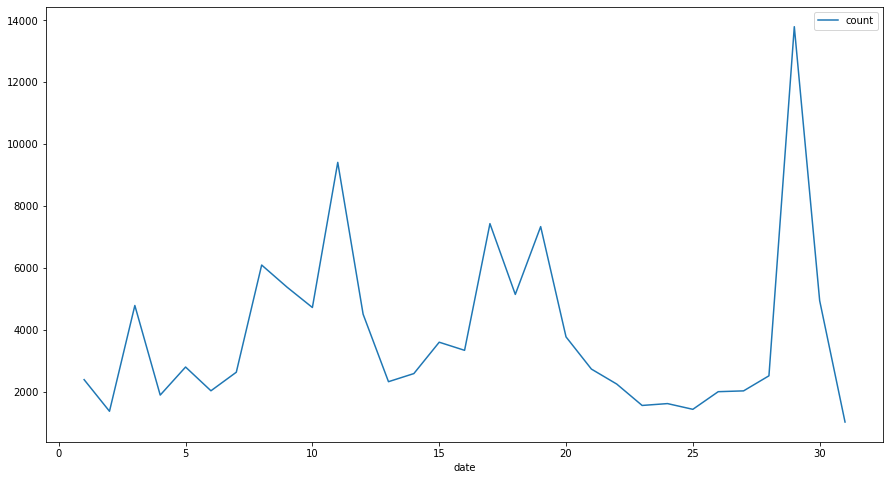

In [74]:
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_year)
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_month)
plt.figure(figsize=(15,8))
sns.lineplot(data=cve_by_day)

## Time analysis conclusion
### If this was all of the vulnerabilities in third-party software, it seems like CVEs are updating less frequently. 
### Does that mean that there are less vulnerability in third-party software? I dont think so. 

### Up until 2016, MITRE which assigngs CVEs had a troublesome process to create CVEs. 
### 2017 the assignment process changed, which led to a substantial increase in CVE, which has already been shown above.
### According to https://www.cvedetails.com/browse-by-date.php   the vulnerabilities are increasing every year. It is very peculiar that this dataset actually shows a decline. It could be that the data set does not show all CVEs, or it could be that the act of updating CVE is getting less fruquent

### When looking at the day and month in which CVE's are updated, it does not seem to follow what statistics say. This again could just be the difference between assignment and update or simply that the data set does not include everything. 
